# Tutorial 1 — Library Fundamentals

This tutorial covers the foundational modules of the LineExtraction Python
bindings: image processing (`le_imgproc`), geometry primitives (`le_geometry`),
and test data loading (`lsfm.data.TestImages`).

**Modules covered:**

| Module | Topics |
|--------|--------|
| `lsfm.data` | `TestImages` — loading windmill, BSDS500, noise, stereo images |
| `le_imgproc` | `Range`, `Value`, `FilterData`, gradient filters (Sobel, Scharr, Prewitt) |
| `le_geometry` | `Line`, `LineSegment`, `Polygon`, drawing utilities, line optimizer |

**Prerequisites:**
- Build bindings: `bazel build //libs/...`
- Familiarity with the concepts in `cv_primer.ipynb`

**Sections:**

1. Setup & Imports
2. Loading Images with TestImages
3. Core Data Types (Range, Value, FilterData)
4. Gradient Filters
5. Multi-Preset Comparison
6. ValueManager Pattern
7. Geometry: Line
8. Geometry: LineSegment
9. Geometry: Polygon
10. Drawing Utilities

---
## 1. Setup & Imports

In [1]:
import sys, pathlib

# --- Locate workspace root and add Bazel output dirs to sys.path ---
workspace = pathlib.Path.cwd()
while not (workspace / "MODULE.bazel").exists():
    if workspace == workspace.parent:
        raise RuntimeError("Cannot find LineExtraction workspace root (MODULE.bazel)")
    workspace = workspace.parent

# Add each binding's Bazel output directory
for lib in ["imgproc", "edge", "geometry", "eval", "lsd"]:
    p = workspace / f"bazel-bin/libs/{lib}/python"
    if p.exists():
        sys.path.insert(0, str(p))
    else:
        print(f"Warning: Not found: {p}  — run: bazel build //libs/{lib}/...")

# Add lsfm package
sys.path.insert(0, str(workspace / "python"))

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# NOTE: We do NOT import cv2. The LE bindings ship their own OpenCV build
# (linked statically via Bazel). Using pip's cv2 would cause symbol conflicts.

import le_imgproc
import le_geometry
from lsfm.data import TestImages

print(f"Workspace: {workspace}")
print(f"le_imgproc loaded: {len([x for x in dir(le_imgproc) if not x.startswith('_')])} symbols")
print(f"le_geometry loaded: {len([x for x in dir(le_geometry) if not x.startswith('_')])} symbols")

Workspace: /home/waterben/workspace/LineExtraction
le_imgproc loaded: 37 symbols
le_geometry loaded: 29 symbols


In [2]:
# --- Common helpers used throughout this tutorial ---

def show_images(images, titles, cmap="gray", figsize=None):
    """Show a list of images side by side."""
    n = len(images)
    if figsize is None:
        figsize = (4 * n, 4)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    if n == 1:
        axes = [axes]
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap=cmap if img.ndim == 2 else None)
        ax.set_title(title, fontsize=10)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

def make_test_image(size=200):
    """Create a uint8 grayscale image with rectangles and diagonal lines."""
    img = np.zeros((size, size), dtype=np.uint8)
    s = size
    img[s//5:4*s//5, s//5:4*s//5] = 200
    img[2*s//5:3*s//5, 2*s//5:3*s//5] = 80
    # Diagonal line
    for i in range(s//5, 4*s//5):
        j = s//5 + (i - s//5)
        if 0 <= j < s:
            img[i, j] = 255
    return img

def bgr_to_rgb(img):
    """Convert BGR image (from LE drawing) to RGB for matplotlib."""
    return img[:, :, ::-1]

print("Helpers ready.")

Helpers ready.


---
## 2. Loading Images with TestImages

The `TestImages` class resolves image paths across Bazel runfiles and
standalone project layouts. It provides convenient accessors for all
datasets included in the project.

Search paths:
  /home/waterben/workspace/LineExtraction/resources
  /home/waterben/workspace/LineExtraction/resources/datasets

Windmill: /home/waterben/workspace/LineExtraction/resources/windmill.jpg
Shape: (448, 300), dtype: uint8


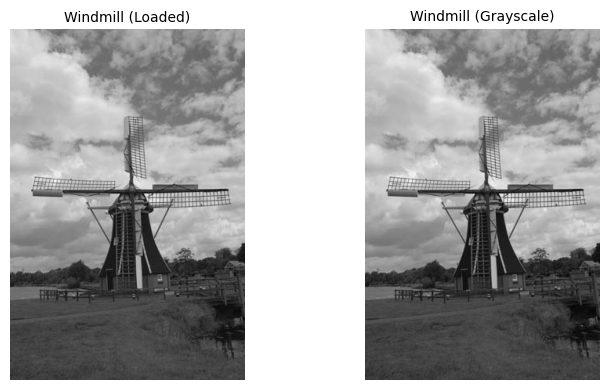

In [21]:
images = TestImages()

# Show available search paths
print("Search paths:")
for p in images.search_paths:
    print(f"  {p}")

# Load windmill image
windmill_path = images.windmill()
print(f"\nWindmill: {windmill_path}")

# Load using matplotlib (no cv2!)
windmill_loaded = plt.imread(str(windmill_path))

# Convert to grayscale (handle already-grayscale images)
def rgb_to_gray(img):
    """Standard luminance grayscale conversion. Handles grayscale input."""
    if img.ndim == 2:
        # Already grayscale - ensure writable copy
        result = img.astype(np.uint8) if img.dtype != np.uint8 else img.copy()
        return result
    # RGB or RGBA
    r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
    return (0.2989 * r + 0.5870 * g + 0.1140 * b).astype(np.uint8)

windmill = rgb_to_gray(windmill_loaded)
windmill_color = windmill_loaded if windmill_loaded.ndim == 3 else np.stack([windmill]*3, axis=-1)
print(f"Shape: {windmill.shape}, dtype: {windmill.dtype}")

show_images([windmill_color, windmill], ["Windmill (Color)" if windmill_loaded.ndim == 3 else "Windmill (Loaded)", "Windmill (Grayscale)"])

BSDS500: 500 images available


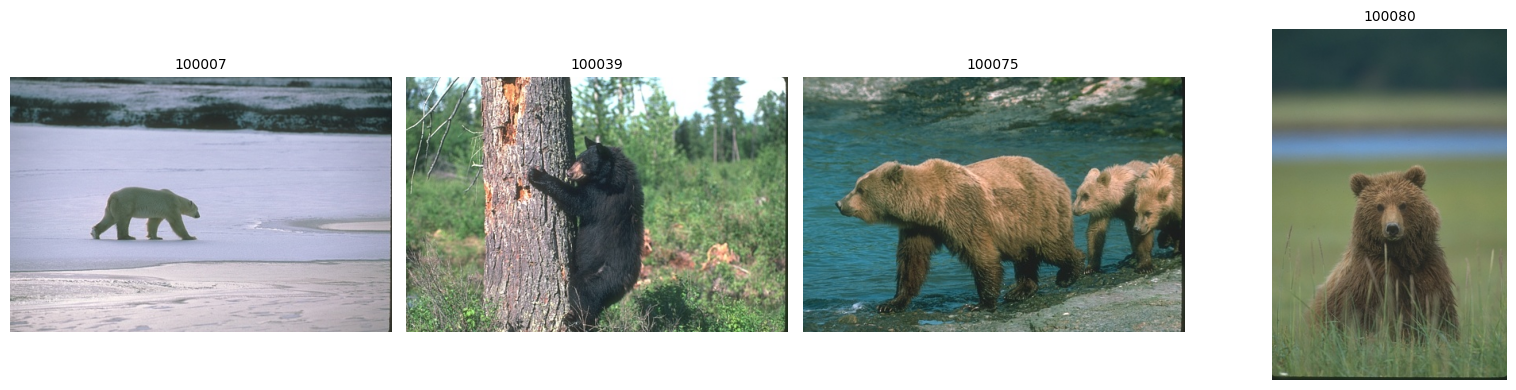

In [5]:
# --- BSDS500 dataset ---
# Load a few BSDS500 images
bsds_paths = list(images.bsds500())  # iterator of all images
print(f"BSDS500: {len(bsds_paths)} images available")

# Show the first 4
bsds_samples = [plt.imread(str(p)) for p in bsds_paths[:4]]
bsds_titles = [p.stem for p in bsds_paths[:4]]
show_images(bsds_samples, bsds_titles)

Noise dataset: 14 images
  bike.png
  bike_noise10.png
  bike_noise20.png
  bike_noise30.png
  bike_noise40.png
  bike_noise50.png
  circle.png
  circle_noise10.png
  circle_noise20.png
  circle_noise30.png
  circle_noise40.png
  circle_noise50.png
  im0_gray.png
  im0_noise_gray.png


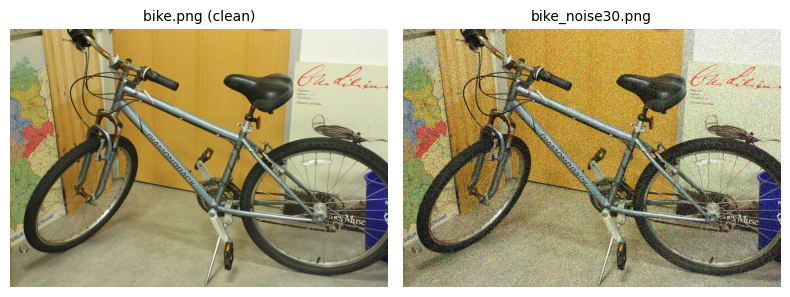

In [6]:
# --- Noise dataset ---
# The noise dataset contains clean images and their noisy variants
noise_paths = list(images.noise_images())
print(f"Noise dataset: {len(noise_paths)} images")
for p in noise_paths:
    print(f"  {p.name}")

# Compare clean bike vs. noisy variant
bike_clean = plt.imread(str(images.noise("bike.png")))
bike_noisy = plt.imread(str(images.noise("bike_noise30.png")))
show_images([bike_clean, bike_noisy], ["bike.png (clean)", "bike_noise30.png"])

Available stereo scenes (Q resolution):
  Adirondack, Australia, Bicycle2, Classroom2, Crusade, Djembe, Hoops, Jadeplant, Livingroom, Motorcycle...

⚠ Stereo pair incomplete: None of [MDB/MiddEval3-Q/Adirondack/im1.png] found.
Searched in:
  /home/waterben/workspace/LineExtraction/resources
  /home/waterben/workspace/LineExtraction/resources/datasets
  Showing available left images only...


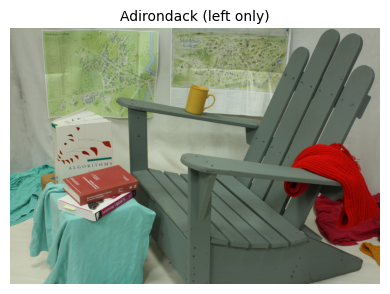

In [8]:
# --- Stereo pairs (MDB) ---
print("Available stereo scenes (Q resolution):")
scenes = list(images.stereo_scenes(resolution="Q"))
print(f"  {', '.join(scenes[:10])}{'...' if len(scenes) > 10 else ''}")

# Load a stereo pair (may not have right image if incomplete dataset)
if scenes:
    try:
        left_path, right_path = images.stereo_pair(scenes[0], resolution="Q")
        left = plt.imread(str(left_path))
        right = plt.imread(str(right_path))
        show_images([left, right], [f"{scenes[0]} — Left", f"{scenes[0]} — Right"])
    except FileNotFoundError as e:
        # Dataset only has left images - show those instead
        print(f"\n⚠ Stereo pair incomplete: {e}")
        print("  Showing available left images only...")
        left_only = images.get(f"MDB/MiddEval3-Q/{scenes[0]}.png")
        if left_only:
            left = plt.imread(str(left_only))
            show_images([left], [f"{scenes[0]} (left only)"])

In [9]:
# --- Generic path resolver ---
# .get() resolves any relative path against the search paths
wm = images.get("windmill.jpg")
print(f"Generic resolve: {wm}")

# You can also resolve dataset-relative paths
bike = images.get("noise/bike.png")
print(f"Noise bike: {bike}")

Generic resolve: /home/waterben/workspace/LineExtraction/resources/windmill.jpg
Noise bike: /home/waterben/workspace/LineExtraction/resources/datasets/noise/bike.png


### Exercise 2.1 — Explore BSDS500

1. Count how many BSDS500 images are available.
2. Load a specific image by name (e.g., `"100007.jpg"`).
3. Display it alongside its grayscale conversion.

In [10]:
# TODO: load a specific BSDS500 image and show color + grayscale

**Solution**

Total BSDS500 images: 500


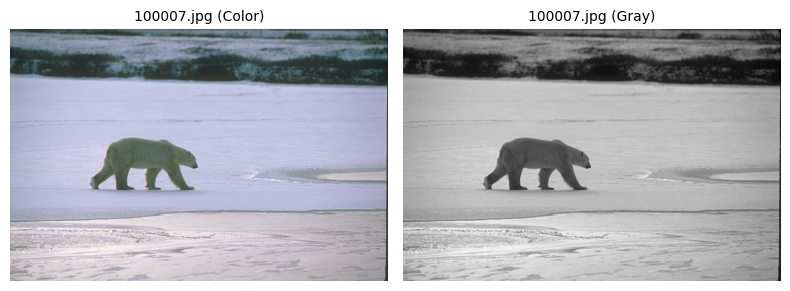

In [11]:
all_bsds = list(images.bsds500())
print(f"Total BSDS500 images: {len(all_bsds)}")

# Pick the first image by name
img_name = all_bsds[0].name
img_path = images.bsds500(img_name)
img_color = plt.imread(str(img_path))
img_gray = rgb_to_gray(img_color)

show_images([img_color, img_gray], [f"{img_name} (Color)", f"{img_name} (Gray)"])

Use `.bsds500(name)` for a single image by name, or `.bsds500()` without
arguments for an iterator over all images.

---
## 3. Core Data Types

The `le_imgproc` module provides three fundamental data types that are used
throughout the library.

### Range

Represents a numeric interval `[lower, upper]`. There are type-specific
variants:

In [12]:
# RangeD (double), RangeF (float), RangeI (int), RangeS (short), etc.
r = le_imgproc.RangeD(0.0, 1.0)
print(f"RangeD: [{r.lower}, {r.upper}], size = {r.size()}")

ri = le_imgproc.RangeI(-128, 127)
print(f"RangeI: [{ri.lower}, {ri.upper}], size = {ri.size()}")

rf = le_imgproc.RangeF(-1.0, 1.0)
print(f"RangeF: [{rf.lower}, {rf.upper}], size = {rf.size()}")

# Swap lower and upper
r2 = le_imgproc.RangeD(0.0, 10.0)
r2.swap()
print(f"After swap: [{r2.lower}, {r2.upper}]")

RangeD: [0.0, 1.0], size = 1.0
RangeI: [-128, 127], size = 255
RangeF: [-1.0, 1.0], size = 2.0
After swap: [10.0, 0.0]


### Value

A type-safe variant that can hold `int`, `float`, `bool`, or `string`.
Used by the ValueManager system for runtime parameter access.

In [13]:
# Create Values of different types
v_int = le_imgproc.Value(42)
v_float = le_imgproc.Value(3.14)
v_bool = le_imgproc.Value(True)
v_str = le_imgproc.Value("hello")

print(f"Int value:    {v_int.get_int()}")
print(f"Float value:  {v_float.get_float()}")
print(f"Bool value:   {v_bool.get_bool()}")
print(f"String value: {v_str.get_string()}")

Int value:    42
Float value:  3.140000104904175
Bool value:   True
String value: hello


### FilterData

Wraps a NumPy array (cv::Mat) together with its value range metadata.
Gradient filters return their results as `FilterData` objects.

In [15]:
# FilterData wraps array + range
arr = np.random.rand(10, 10).astype(np.float32)
fd = le_imgproc.FilterData(arr, 0.0, 1.0)  # (data, lower, upper)

print(f"FilterData shape: {fd.data.shape}")
print(f"FilterData range: [{fd.range.lower}, {fd.range.upper}]")

# Round-trip: the data array is accessible directly
assert np.allclose(fd.data, arr)
print("Round-trip consistency: ✓")

FilterData shape: (10, 10)
FilterData range: [0.0, 1.0]
Round-trip consistency: ✓


### Exercise 3.1 — Range Arithmetic

1. Create a `RangeI` for uint8 images: [0, 255].
2. Create a `RangeF` for Sobel int16 gradients: [-1020, 1020].
3. Print each range's size.
4. What is the relationship between the gradient range and the uint8 range?
   (Hint: the maximum possible Sobel response for uint8 input is 4 × 255 = 1020.)

In [16]:
# TODO: create ranges and explore their properties

**Solution**

In [17]:
r_uint8 = le_imgproc.RangeI(0, 255)
r_sobel = le_imgproc.RangeF(-1020.0, 1020.0)

print(f"uint8 range size: {r_uint8.size()}")
print(f"Sobel range size: {r_sobel.size()}")
print(f"\nSobel max = 4 × 255 = {4 * 255}")
print(f"The Sobel kernel weights sum to |−1 + 0 + 1| + |−2 + 0 + 2| + |−1 + 0 + 1| = 4")
print(f"So max gradient = 4 × max_pixel_value = 4 × 255 = 1020")

uint8 range size: 255
Sobel range size: 2040.0

Sobel max = 4 × 255 = 1020
The Sobel kernel weights sum to |−1 + 0 + 1| + |−2 + 0 + 2| + |−1 + 0 + 1| = 4
So max gradient = 4 × max_pixel_value = 4 × 255 = 1020


The gradient range is determined by the kernel weights multiplied by the
maximum possible input value. This is important for choosing thresholds.

---
## 4. Gradient Filters

The library provides three gradient filter families, each with four precision
presets:

| Filter | Variants |
|--------|----------|
| `SobelGradient` | (default), `_16u`, `_f32`, `_f64` |
| `ScharrGradient` | (default), `_16u`, `_f32`, `_f64` |
| `PrewittGradient` | (default), `_16u`, `_f32`, `_f64` |

The default preset takes `uint8` input and produces `int16` gradients
with `float32` magnitude.

### Basic Workflow

Filter name: derivative_sobel
Input range: 0 to 255
Magnitude range: 0.0 to 1140.3946533203125
Direction range: -3.142 to 3.142


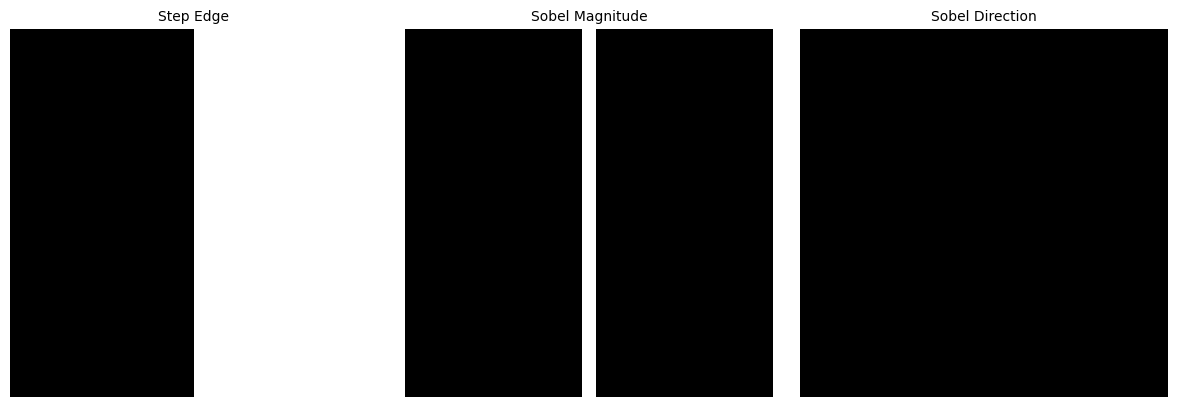

In [18]:
# First, demonstrate on a synthetic step edge for clarity
step = np.zeros((50, 50), dtype=np.uint8)
step[:, 25:] = 200

sobel = le_imgproc.SobelGradient()
sobel.process(step)

print(f"Filter name: {sobel.name()}")
print(f"Input range: {sobel.intensity_range().lower} to {sobel.intensity_range().upper}")
print(f"Magnitude range: {sobel.magnitude_range().lower} to {sobel.magnitude_range().upper}")
print(f"Direction range: {sobel.direction_range().lower:.3f} to {sobel.direction_range().upper:.3f}")

show_images(
    [step, sobel.magnitude(), sobel.direction()],
    ["Step Edge", "Sobel Magnitude", "Sobel Direction"]
)

In [19]:
# All gradient components
print(f"gx shape: {sobel.gx().shape}, dtype: {sobel.gx().dtype}")
print(f"gy shape: {sobel.gy().shape}, dtype: {sobel.gy().dtype}")
print(f"mag shape: {sobel.magnitude().shape}, dtype: {sobel.magnitude().dtype}")
print(f"dir shape: {sobel.direction().shape}, dtype: {sobel.direction().dtype}")

# The results() method returns all components as a dict of FilterData
results = sobel.results()
for name, fd in results.items():
    print(f"  {name:5s}: shape={fd.data.shape}, range=[{fd.range.lower:.1f}, {fd.range.upper:.1f}]")

gx shape: (50, 50), dtype: int16
gy shape: (50, 50), dtype: int16
mag shape: (50, 50), dtype: float32
dir shape: (50, 50), dtype: float32
  dir  : shape=(50, 50), range=[-3.1, 3.1]
  gx   : shape=(50, 50), range=[-1020.0, 1020.0]
  gy   : shape=(50, 50), range=[-1020.0, 1020.0]
  mag  : shape=(50, 50), range=[0.0, 1140.4]


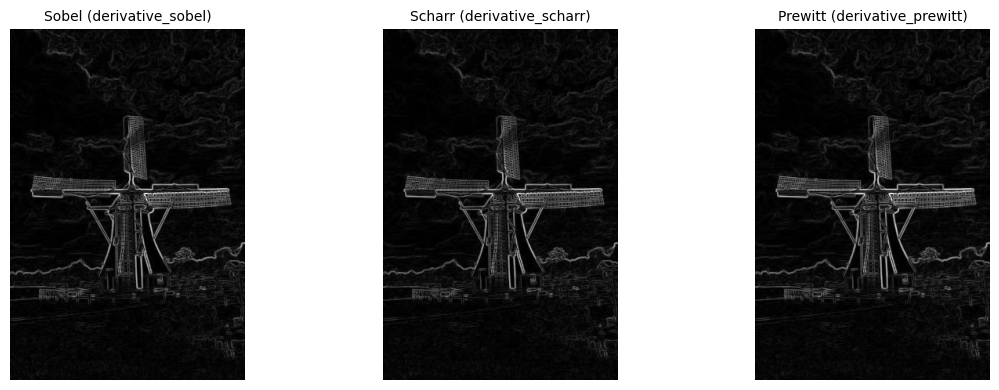

In [22]:
# Now apply to the real windmill image
sobel_wm = le_imgproc.SobelGradient()
scharr_wm = le_imgproc.ScharrGradient()
prewitt_wm = le_imgproc.PrewittGradient()

sobel_wm.process(windmill)
scharr_wm.process(windmill)
prewitt_wm.process(windmill)

show_images(
    [sobel_wm.magnitude(), scharr_wm.magnitude(), prewitt_wm.magnitude()],
    [f"Sobel ({sobel_wm.name()})", f"Scharr ({scharr_wm.name()})", f"Prewitt ({prewitt_wm.name()})"]
)

Relative threshold 0.01 → absolute 11.40


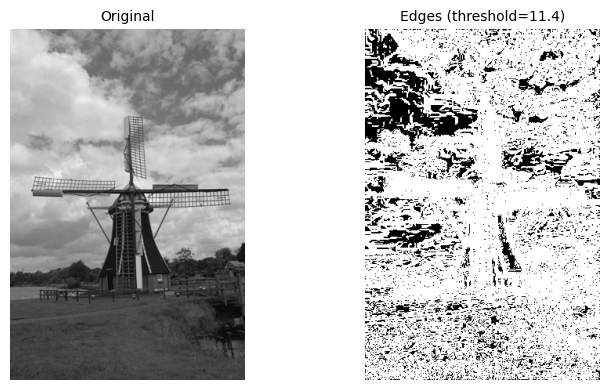

In [23]:
# Magnitude thresholding — convert a relative threshold to absolute
relative_th = 0.01  # 1% of max range
abs_th = sobel_wm.magnitude_threshold(relative_th)
print(f"Relative threshold {relative_th} → absolute {abs_th:.2f}")

# Show thresholded edges
edges = sobel_wm.magnitude() > abs_th
show_images([windmill, edges.astype(float)], ["Original", f"Edges (threshold={abs_th:.1f})"])

### Exercise 4.1 — Gradient Comparison

1. Load a BSDS500 image and convert it to grayscale.
2. Apply all three gradient filters (Sobel, Scharr, Prewitt).
3. Display the three gradient magnitudes side by side.
4. Also display the gradient directions side by side.
5. Which filter produces the sharpest edges?

In [24]:
# TODO: load BSDS500 image, apply 3 filters, show magnitudes and directions

**Solution**

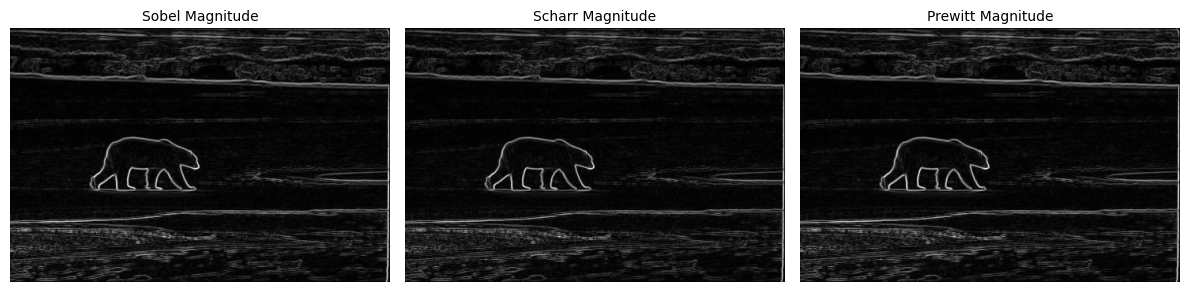

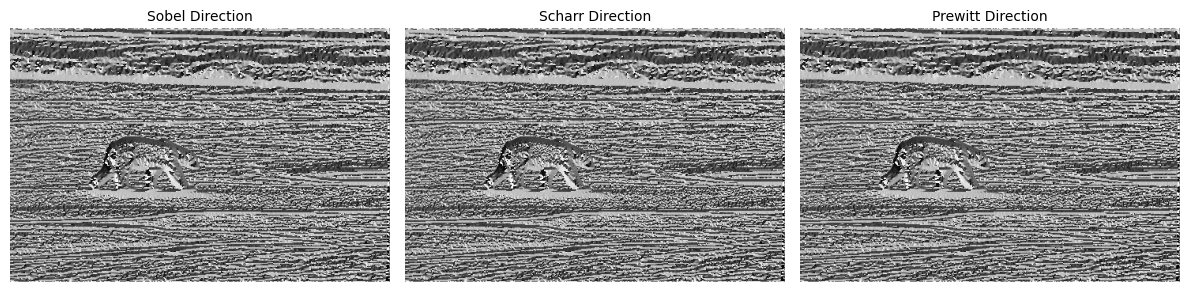

In [25]:
bsds_img_path = list(images.bsds500())[0]
bsds_color = plt.imread(str(bsds_img_path))
bsds_gray = rgb_to_gray(bsds_color)

filters = {
    "Sobel": le_imgproc.SobelGradient(),
    "Scharr": le_imgproc.ScharrGradient(),
    "Prewitt": le_imgproc.PrewittGradient(),
}

for name, f in filters.items():
    f.process(bsds_gray)

# Magnitudes
show_images(
    [f.magnitude() for f in filters.values()],
    [f"{n} Magnitude" for n in filters.keys()]
)

# Directions
show_images(
    [f.direction() for f in filters.values()],
    [f"{n} Direction" for n in filters.keys()]
)

Scharr typically produces the sharpest edges because its kernel has better
rotational symmetry. Prewitt is the simplest but less noise-robust.

### Exercise 4.2 — Gradient Components (gx, gy)

1. Apply Sobel to the windmill image.
2. Display `gx()` and `gy()` side by side.
3. Which edges are highlighted by `gx`? Which by `gy`?
4. Compute the magnitude manually as `np.sqrt(gx**2 + gy**2)` and compare
   with `.magnitude()`.

In [26]:
# TODO: show gx, gy, manual magnitude vs library magnitude

**Solution**

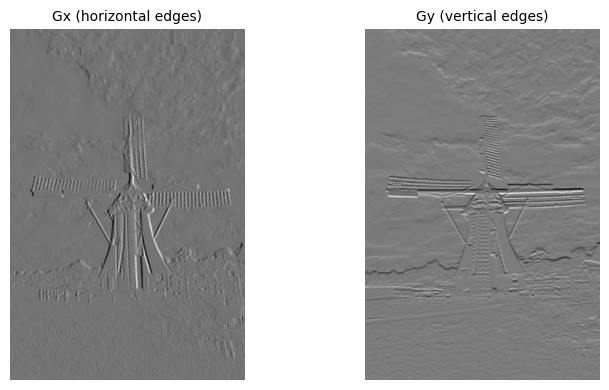

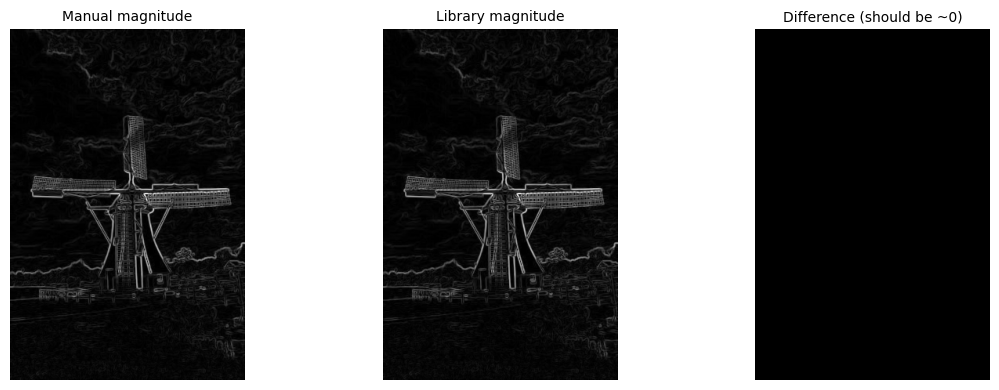

Max difference: 0.000000


In [27]:
sobel_wm.process(windmill)
gx = sobel_wm.gx().astype(np.float32)
gy = sobel_wm.gy().astype(np.float32)
mag_manual = np.sqrt(gx**2 + gy**2)
mag_lib = sobel_wm.magnitude()

show_images([gx, gy], ["Gx (horizontal edges)", "Gy (vertical edges)"])
show_images(
    [mag_manual, mag_lib, np.abs(mag_manual - mag_lib)],
    ["Manual magnitude", "Library magnitude", "Difference (should be ~0)"]
)
print(f"Max difference: {np.max(np.abs(mag_manual - mag_lib)):.6f}")

`gx` highlights vertical edges (brightness changes left↔right), `gy`
highlights horizontal edges (top↔bottom). The manual magnitude matches
the library's to floating-point precision.

---
## 5. Multi-Preset Comparison

Each gradient filter comes in four presets, optimized for different input
data types:

| Suffix | Input dtype | Gradient dtype | Use case |
|--------|-------------|----------------|----------|
| (none) | `uint8` | `int16` | Standard 8-bit images |
| `_16u` | `uint16` | `float32` | 16-bit sensor data |
| `_f32` | `float32` | `float32` | Pre-processed float images |
| `_f64` | `float64` | `float64` | Maximum precision |

Default  — gx dtype: int16, mag dtype: float32
Float32  — gx dtype: float32, mag dtype: float32
Float64  — gx dtype: float64, mag dtype: float64


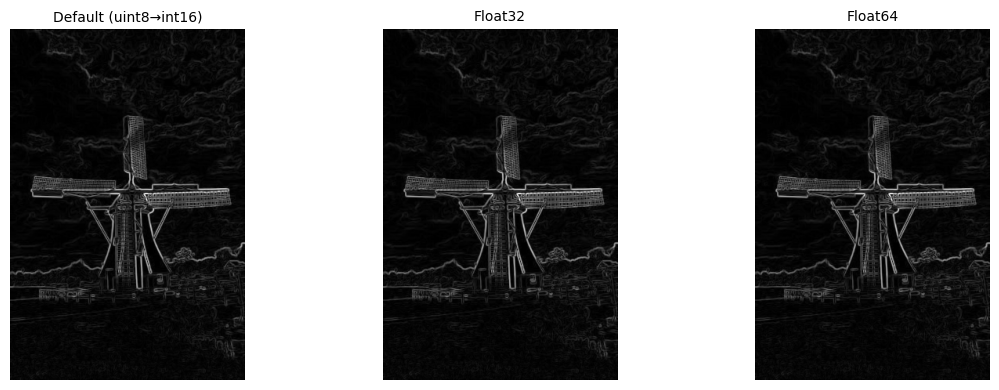

In [28]:
# Compare presets on the same image
# Default (uint8 → int16)
s_default = le_imgproc.SobelGradient()
s_default.process(windmill)

# Float32 preset
s_f32 = le_imgproc.SobelGradient_f32()
windmill_f32 = windmill.astype(np.float32) / 255.0
s_f32.process(windmill_f32)

# Float64 preset
s_f64 = le_imgproc.SobelGradient_f64()
windmill_f64 = windmill.astype(np.float64) / 255.0
s_f64.process(windmill_f64)

print(f"Default  — gx dtype: {s_default.gx().dtype}, mag dtype: {s_default.magnitude().dtype}")
print(f"Float32  — gx dtype: {s_f32.gx().dtype}, mag dtype: {s_f32.magnitude().dtype}")
print(f"Float64  — gx dtype: {s_f64.gx().dtype}, mag dtype: {s_f64.magnitude().dtype}")

show_images(
    [s_default.magnitude(), s_f32.magnitude(), s_f64.magnitude()],
    ["Default (uint8→int16)", "Float32", "Float64"]
)

The visual results are nearly identical, but the underlying precision differs.
Use the default preset for typical 8-bit images. Use `_f32` or `_f64` when
working with pre-processed float data or when you need maximum numerical
accuracy.

---
## 6. ValueManager Pattern

All major library objects support the **ValueManager** interface for runtime
parameter inspection and modification. This is a uniform way to discover
and change parameters without knowing the specific class API.

In [29]:
sobel = le_imgproc.SobelGradient()

# List all available parameters
print("Parameters of SobelGradient:")
for name, value in sobel.values().items():
    # Try to figure out the type and get the value
    try:
        v = value.get_int()
        print(f"  {name} = {v} (int)")
    except Exception:
        try:
            v = value.get_float()
            print(f"  {name} = {v} (float)")
        except Exception:
            try:
                v = value.get_string()
                print(f"  {name} = '{v}' (string)")
            except Exception:
                print(f"  {name} = ? (unknown type)")

Parameters of SobelGradient:
  grad_kernel_size = 3 (int)


Current grad_kernel_size: 3
After set_int: 5


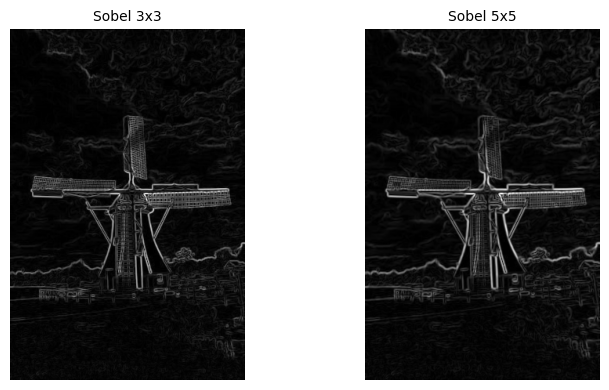

In [31]:
# Get and set values by name (note: param name is "grad_kernel_size")
val = sobel.get_value("grad_kernel_size")
print(f"Current grad_kernel_size: {val.get_int()}")

# Change it (Sobel supports kernel sizes 1, 3, 5, 7)
sobel.set_int("grad_kernel_size", 5)
print(f"After set_int: {sobel.get_value('grad_kernel_size').get_int()}")

# Process with larger kernel and compare
sobel3 = le_imgproc.SobelGradient()  # default kernel_size=3
sobel5 = le_imgproc.SobelGradient()
sobel5.set_int("grad_kernel_size", 5)

sobel3.process(windmill)
sobel5.process(windmill)

show_images(
    [sobel3.magnitude(), sobel5.magnitude()],
    ["Sobel 3x3", "Sobel 5x5"]
)

The larger 5×5 kernel produces smoother gradients with more spatial
averaging. The ValueManager pattern is used consistently across all
modules — gradient filters, edge detectors, and line segment detectors
all support `.values()`, `.get_value()`, `.set_int()`, `.set_double()`.

---
## 7. Geometry: Line

The `Line` class represents an infinite 2D line in **Hesse normal form**:
a unit normal vector $(n_x, n_y)$ and a signed origin distance $d$.

Two presets: `Line` (float32) and `Line_f64` (float64).

In [32]:
# Construction: Line(nx, ny, dist)
line = le_geometry.Line(0.6, 0.8, 100.0)

print(f"Normal: ({line.normal_x:.3f}, {line.normal_y:.3f})")
print(f"Origin distance: {line.origin_dist:.1f}")
print(f"Angle: {np.degrees(line.angle):.1f}°")
print(f"Normal angle: {np.degrees(line.normal_angle):.1f}°")
print(f"Normal vector: {line.normal()}")
print(f"Direction vector: {line.direction()}")
print(f"Closest point to origin: {line.origin_point()}")
print(f"Valid: {line.valid()}, Empty: {line.empty()}")

Normal: (0.600, 0.800)
Origin distance: 100.0
Angle: -36.9°
Normal angle: 53.1°
Normal vector: (0.6000000238418579, 0.800000011920929)
Direction vector: (0.800000011920929, -0.6000000238418579)
Closest point to origin: (60.000003814697266, 80.0)
Valid: True, Empty: False


In [33]:
# Alternative construction: Line(nx, ny, point_x, point_y)
# Creates a line with given normal passing through the point
line2 = le_geometry.Line(1.0, 0.0, 50.0, 100.0)  # vertical line at x=50
print(f"Line through (50, 100) with normal (1, 0):")
print(f"  origin_dist = {line2.origin_dist:.1f} (should be 50)")
print(f"  y at x=50: {line2.y_at(50.0)}")  # should be any y

Line through (50, 100) with normal (1, 0):
  origin_dist = 50.0 (should be 50)
  y at x=50: nan


In [34]:
# Distance and projection
print(f"Distance from (0,0) to line: {line.distance(0.0, 0.0):.1f}")
print(f"Distance from (60,80) to line: {line.distance(60.0, 80.0):.1f}")

# Project a point onto the line
proj = line.project(0.0, 0.0)
print(f"Projection of origin onto line: {proj}")

# x_at, y_at: find coordinates on the line
print(f"x at y=50: {line.x_at(50.0):.1f}")
print(f"y at x=50: {line.y_at(50.0):.1f}")

Distance from (0,0) to line: -100.0
Distance from (60,80) to line: 0.0
Projection of origin onto line: 0.0
x at y=50: 100.0
y at x=50: 87.5


In [35]:
# Intersection
line_a = le_geometry.Line(0.6, 0.8, 100.0)
line_b = le_geometry.Line(1.0, 0.0, 80.0)  # vertical line at x=80

intersection = line_a.intersection(line_b)
if intersection is not None:
    print(f"Intersection: ({intersection[0]:.1f}, {intersection[1]:.1f})")

# Parallel check
line_c = le_geometry.Line(0.6, 0.8, 200.0)  # parallel to line_a
print(f"a parallel to b? {line_a.is_parallel(line_b)}")
print(f"a parallel to c? {line_a.is_parallel(line_c)}")
print(f"Angle between a and b: {np.degrees(line_a.angle_to(line_b)):.1f}°")

Intersection: (80.0, 65.0)
a parallel to b? False
a parallel to c? True
Angle between a and b: 53.1°


In [36]:
# Transforms — create new lines
translated = line.translated_ortho(20.0)  # shift 20 units along normal
print(f"Translated dist: {translated.origin_dist:.1f} (was {line.origin_dist:.1f})")

rotated = line.rotated(np.radians(45))  # rotate 45 degrees
print(f"Rotated angle: {np.degrees(rotated.angle):.1f}°")

flipped = line.normal_flipped()  # flip normal direction
print(f"Flipped normal: ({flipped.normal_x:.3f}, {flipped.normal_y:.3f})")

# world2line / line2world coordinate transforms
lx, ly = line.world2line(60.0, 80.0)
print(f"\nWorld (60, 80) → Line coords: ({lx:.1f}, {ly:.1f})")
wx, wy = line.line2world(lx, ly)
print(f"Line ({lx:.1f}, {ly:.1f}) → World: ({wx:.1f}, {wy:.1f})")

Translated dist: 120.0 (was 100.0)
Rotated angle: 8.1°
Flipped normal: (-0.600, -0.800)

World (60, 80) → Line coords: (0.0, 100.0)
Line (0.0, 100.0) → World: (60.0, 80.0)


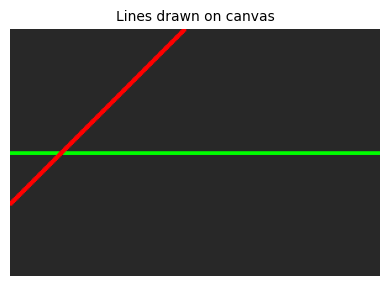

In [37]:
# Draw a line on an image
canvas = np.full((200, 300, 3), 40, dtype=np.uint8)  # dark gray BG

demo_line = le_geometry.Line(0.0, 1.0, 100.0)  # horizontal at y=100
demo_line.draw(canvas, (0, 255, 0, 255), 2)  # green, thickness 2

diag_line = le_geometry.Line(0.707, 0.707, 100.0)  # 45° diagonal
diag_line.draw(canvas, (0, 0, 255, 255), 2)  # red (BGR!)

show_images([bgr_to_rgb(canvas)], ["Lines drawn on canvas"])

### Exercise 7.1 — Line Operations

1. Create two lines that are perpendicular (90° apart).
2. Find their intersection point.
3. Compute the distance from point (200, 200) to each line.
4. Draw both lines and mark the intersection on a 400×400 canvas.

In [38]:
# TODO: create perpendicular lines, find intersection, draw

**Solution**

Intersection: (200, 150)
Distance (200,200) to h_line: 50.0
Distance (200,200) to v_line: 0.0


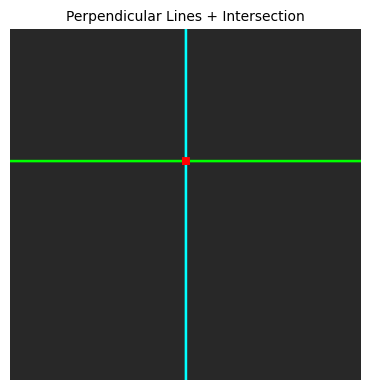

In [39]:
# Horizontal line at y=150
h_line = le_geometry.Line(0.0, 1.0, 150.0)
# Vertical line at x=200
v_line = le_geometry.Line(1.0, 0.0, 200.0)

# Intersection
isect = h_line.intersection(v_line)
print(f"Intersection: ({isect[0]:.0f}, {isect[1]:.0f})")

# Distances
print(f"Distance (200,200) to h_line: {h_line.distance(200.0, 200.0):.1f}")
print(f"Distance (200,200) to v_line: {v_line.distance(200.0, 200.0):.1f}")

# Draw
canvas = np.full((400, 400, 3), 40, dtype=np.uint8)
h_line.draw(canvas, (0, 255, 0, 255), 2)
v_line.draw(canvas, (255, 255, 0, 255), 2)
# Mark intersection (draw a small filled circle manually)
ix, iy = int(isect[0]), int(isect[1])
canvas[max(0,iy-4):iy+5, max(0,ix-4):ix+5] = [0, 0, 255]
show_images([bgr_to_rgb(canvas)], ["Perpendicular Lines + Intersection"])

Two lines with normals (0,1) and (1,0) are perpendicular. Their
intersection is at (200, 150) where the vertical meets the horizontal.

---
## 8. Geometry: LineSegment

`LineSegment` extends `Line` with start and end positions, giving it finite
length. The most convenient constructor is `from_endpoints()`.

In [40]:
# Create from endpoints
seg = le_geometry.LineSegment.from_endpoints(50.0, 30.0, 250.0, 180.0)

print(f"Start: {seg.start_point()}")
print(f"End:   {seg.end_point()}")
print(f"Center: {seg.center_point()}")
print(f"Length: {seg.length:.1f}")
print(f"All endpoints: {seg.end_points()}")
print(f"Angle: {np.degrees(seg.angle):.1f}°")

# Inherited Line properties
print(f"Normal: ({seg.normal_x:.3f}, {seg.normal_y:.3f})")
print(f"Origin distance: {seg.origin_dist:.1f}")

Start: (50.000003814697266, 30.000001907348633)
End:   (250.00001525878906, 180.0)
Center: (150.00001525878906, 105.0)
Length: 250.0
All endpoints: (50.000003814697266, 30.000001907348633, 250.00001525878906, 180.0)
Angle: 36.9°
Normal: (-0.600, 0.800)
Origin distance: -6.0


In [41]:
# Range checks — is a position along the segment?
print(f"Start pos: {seg.start:.1f}")
print(f"End pos:   {seg.end:.1f}")
print(f"Center dist: {seg.center_dist:.1f}")
print(f"In range (center): {seg.in_range(seg.center_dist)}")
print(f"In range (far away): {seg.in_range(999.0)}")

# Check if a point is within the segment's range
print(f"Point (150, 105) in range: {seg.in_range_point(150.0, 105.0)}")
print(f"Point (0, 0) in range: {seg.in_range_point(0.0, 0.0)}")

Start pos: 58.0
End pos:   308.0
Center dist: 183.0
In range (center): True
In range (far away): False
Point (150, 105) in range: True
Point (0, 0) in range: False


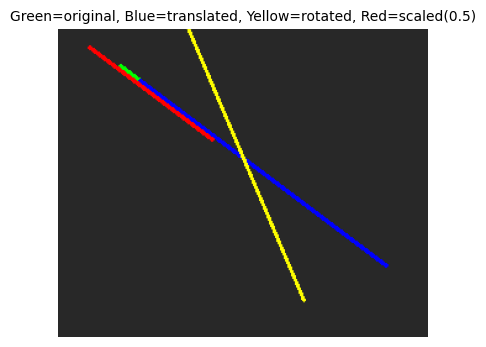

In [43]:
# Transforms
trans_seg = seg.translated(20.0)  # shift 20 units along normal
rot_seg = seg.rotated(np.radians(30), seg.center_dist)  # rotate around center (pivot as distance along line)
scaled_seg = seg.scaled(0.5)  # half length, same center
flipped_seg = seg.endpoint_swapped()  # swap start/end

# Draw all on a canvas
canvas = np.full((250, 300, 3), 40, dtype=np.uint8)
seg.draw(canvas, (0, 255, 0, 255), 2)       # original: green
trans_seg.draw(canvas, (255, 0, 0, 255), 2)  # translated: blue
rot_seg.draw(canvas, (0, 255, 255, 255), 2)  # rotated: yellow
scaled_seg.draw(canvas, (0, 0, 255, 255), 2) # scaled: red

show_images(
    [bgr_to_rgb(canvas)],
    ["Green=original, Blue=translated, Yellow=rotated, Red=scaled(0.5)"]
)

Original: (-50.000003814697266, -20.0) → (350.0, 280.0000305175781)
Trimmed:  (0.0, 17.500003814697266) → (300.0, 242.5)


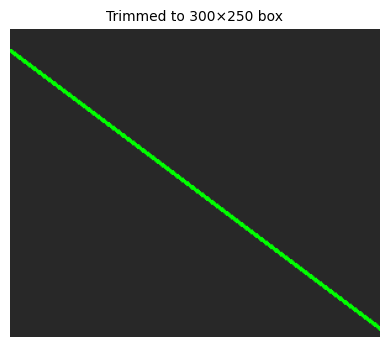

In [44]:
# Trim to bounding box — clips endpoints to image boundaries
long_seg = le_geometry.LineSegment.from_endpoints(-50.0, -20.0, 350.0, 280.0)
trimmed = long_seg.trim_to_box(300, 250, 0, 0)

canvas = np.full((250, 300, 3), 40, dtype=np.uint8)
trimmed.draw(canvas, (0, 255, 0, 255), 2)
print(f"Original: {long_seg.start_point()} → {long_seg.end_point()}")
print(f"Trimmed:  {trimmed.start_point()} → {trimmed.end_point()}")
show_images([bgr_to_rgb(canvas)], ["Trimmed to 300×250 box"])

In [45]:
# Overlap check and error
seg1 = le_geometry.LineSegment.from_endpoints(10.0, 10.0, 100.0, 10.0)
seg2 = le_geometry.LineSegment.from_endpoints(50.0, 10.0, 150.0, 10.0)  # overlapping
seg3 = le_geometry.LineSegment.from_endpoints(10.0, 50.0, 100.0, 50.0)  # parallel, no overlap

print(f"seg1 overlaps seg2? {seg1.check_overlap(seg2)}")
print(f"seg1 overlaps seg3? {seg1.check_overlap(seg3)}")

# Error: average orthogonal distance to a reference line
ref_line = le_geometry.Line(0.0, 1.0, 10.0)  # horizontal at y=10
seg_near = le_geometry.LineSegment.from_endpoints(10.0, 11.0, 100.0, 11.0)
seg_far = le_geometry.LineSegment.from_endpoints(10.0, 20.0, 100.0, 20.0)
print(f"Error of near segment: {seg_near.error(ref_line):.2f}")
print(f"Error of far segment: {seg_far.error(ref_line):.2f}")

seg1 overlaps seg2? True
seg1 overlaps seg3? True
Error of near segment: 2.00
Error of far segment: 20.00


### Exercise 8.1 — Building a Star Pattern

1. Create 8 line segments radiating from a center point (200, 200),
   each 100 pixels long, evenly spaced at 45° intervals.
2. Draw them on a 400×400 canvas using different colors.
3. Print the length and angle of each segment.

In [46]:
# TODO: create 8 radial segments and draw them

**Solution**

Segment 0: angle=    0°, length=100.0
Segment 1: angle=   45°, length=100.0
Segment 2: angle=   90°, length=100.0
Segment 3: angle=  135°, length=100.0
Segment 4: angle=  180°, length=100.0
Segment 5: angle=  225°, length=100.0
Segment 6: angle=  270°, length=100.0
Segment 7: angle=  315°, length=100.0


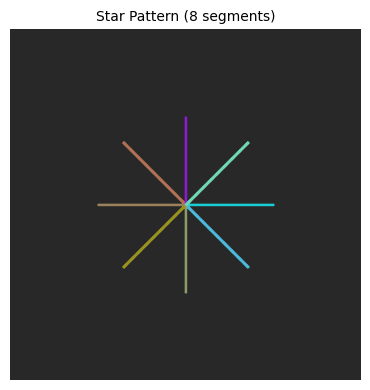

In [47]:
canvas = np.full((400, 400, 3), 40, dtype=np.uint8)
cx, cy = 200.0, 200.0
radius = 100.0

for i in range(8):
    angle = i * np.pi / 4  # 0, 45, 90, ..., 315 degrees
    ex = cx + radius * np.cos(angle)
    ey = cy + radius * np.sin(angle)
    seg = le_geometry.LineSegment.from_endpoints(cx, cy, ex, ey)
    color = le_geometry.random_color()
    seg.draw(canvas, color, 2)
    print(f"Segment {i}: angle={np.degrees(angle):5.0f}°, length={seg.length:.1f}")

show_images([bgr_to_rgb(canvas)], ["Star Pattern (8 segments)"])

We used `from_endpoints()` with center + radius·cos/sin for each angle.
`random_color()` generates a random BGRA tuple for colorful visualization.

---
## 9. Geometry: Polygon

The `Polygon` class represents a 2D polygon defined by an ordered list
of vertices.

In [48]:
# Create a polygon
poly = le_geometry.Polygon()
poly.add_vertex(100.0, 50.0)
poly.add_vertex(250.0, 50.0)
poly.add_vertex(280.0, 150.0)
poly.add_vertex(200.0, 200.0)
poly.add_vertex(70.0, 150.0)

print(f"Size: {poly.size}")
print(f"Empty: {poly.empty}")
print(f"Is convex: {poly.is_convex}")
print(f"Vertices: {poly.vertices}")

Size: 5
Empty: False
Is convex: True
Vertices: <bound method PyCapsule.vertices of Polygon(vertices=5, convex=True)>


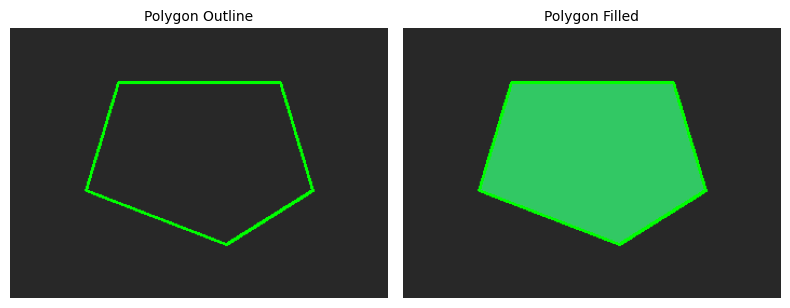

In [49]:
# Draw and fill
canvas_outline = np.full((250, 350, 3), 40, dtype=np.uint8)
canvas_filled = np.full((250, 350, 3), 40, dtype=np.uint8)

poly.draw(canvas_outline, (0, 255, 0, 255), 2)   # outline
poly.fill(canvas_filled, (100, 200, 50, 255))     # filled
poly.draw(canvas_filled, (0, 255, 0, 255), 2)     # outline on top

show_images(
    [bgr_to_rgb(canvas_outline), bgr_to_rgb(canvas_filled)],
    ["Polygon Outline", "Polygon Filled"]
)

Star polygon — convex: False


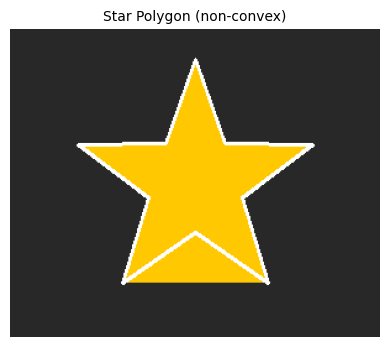

In [50]:
# Non-convex polygon example
star = le_geometry.Polygon()
center = (150.0, 125.0)
for i in range(5):
    # Outer point
    angle = i * 2 * np.pi / 5 - np.pi / 2
    star.add_vertex(center[0] + 100 * np.cos(angle),
                    center[1] + 100 * np.sin(angle))
    # Inner point
    angle += np.pi / 5
    star.add_vertex(center[0] + 40 * np.cos(angle),
                    center[1] + 40 * np.sin(angle))

print(f"Star polygon — convex: {star.is_convex}")

canvas = np.full((250, 300, 3), 40, dtype=np.uint8)
star.fill(canvas, (0, 200, 255, 255))
star.draw(canvas, (255, 255, 255, 255), 2)
show_images([bgr_to_rgb(canvas)], ["Star Polygon (non-convex)"])

### Exercise 9.1 — Regular Polygon

1. Write a function that creates a regular N-sided polygon centered at
   a given point with a given radius.
2. Create a hexagon (N=6) and a triangle (N=3).
3. Draw both filled on the same canvas.
4. Are both convex?

In [51]:
# TODO: create a regular polygon function, draw hexagon and triangle

**Solution**

Hexagon convex: True
Triangle convex: True


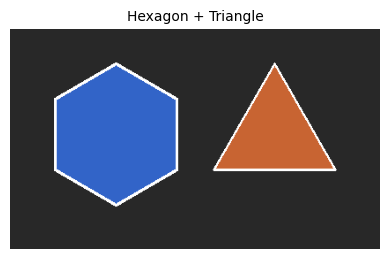

In [52]:
def make_regular_polygon(n, cx, cy, radius):
    """Create a regular n-gon centered at (cx, cy)."""
    poly = le_geometry.Polygon()
    for i in range(n):
        angle = i * 2 * np.pi / n - np.pi / 2
        poly.add_vertex(cx + radius * np.cos(angle),
                        cy + radius * np.sin(angle))
    return poly

hexagon = make_regular_polygon(6, 120.0, 120.0, 80.0)
triangle = make_regular_polygon(3, 300.0, 120.0, 80.0)

print(f"Hexagon convex: {hexagon.is_convex}")
print(f"Triangle convex: {triangle.is_convex}")

canvas = np.full((250, 420, 3), 40, dtype=np.uint8)
hexagon.fill(canvas, (200, 100, 50, 255))
hexagon.draw(canvas, (255, 255, 255, 255), 2)
triangle.fill(canvas, (50, 100, 200, 255))
triangle.draw(canvas, (255, 255, 255, 255), 2)
show_images([bgr_to_rgb(canvas)], ["Hexagon + Triangle"])

Regular polygons are always convex. The function uses evenly-spaced
angles to place vertices on a circle.

---
## 10. Drawing Utilities

The `le_geometry` module provides several high-level drawing functions
for working with collections of line segments.

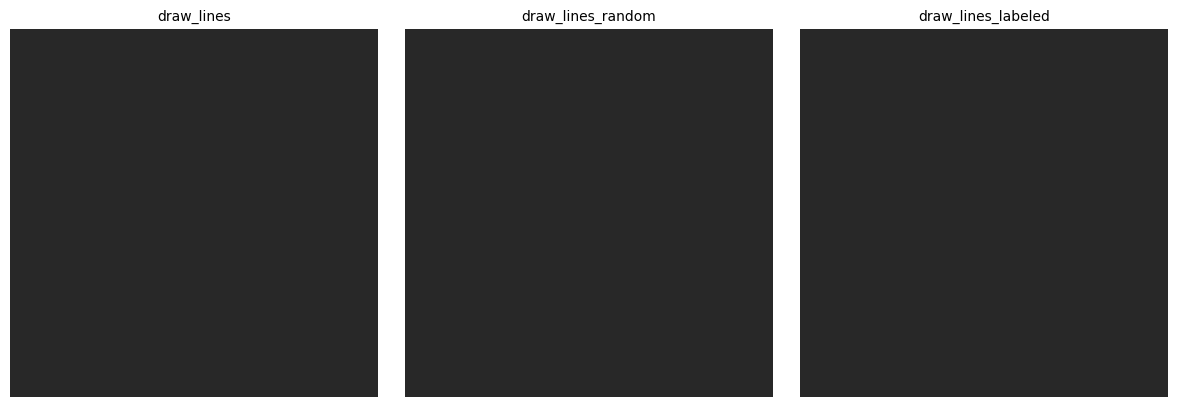

In [53]:
# Create some sample segments
segments = [
    le_geometry.LineSegment.from_endpoints(20.0, 30.0, 180.0, 30.0),
    le_geometry.LineSegment.from_endpoints(20.0, 80.0, 180.0, 140.0),
    le_geometry.LineSegment.from_endpoints(100.0, 20.0, 100.0, 180.0),
    le_geometry.LineSegment.from_endpoints(30.0, 170.0, 170.0, 170.0),
    le_geometry.LineSegment.from_endpoints(150.0, 40.0, 190.0, 160.0),
]

# draw_lines — uniform color
canvas1 = np.full((200, 200, 3), 40, dtype=np.uint8)
le_geometry.draw_lines(canvas1, segments)

# draw_lines_random — each segment gets a random color
canvas2 = np.full((200, 200, 3), 40, dtype=np.uint8)
le_geometry.draw_lines_random(canvas2, segments)

# draw_lines_labeled — segments with text labels
canvas3 = np.full((200, 200, 3), 40, dtype=np.uint8)
labels = ["H-line", "Diag", "V-line", "Bottom", "Right"]
le_geometry.draw_lines_labeled(canvas3, segments, labels)

show_images(
    [bgr_to_rgb(canvas1), bgr_to_rgb(canvas2), bgr_to_rgb(canvas3)],
    ["draw_lines", "draw_lines_random", "draw_lines_labeled"]
)

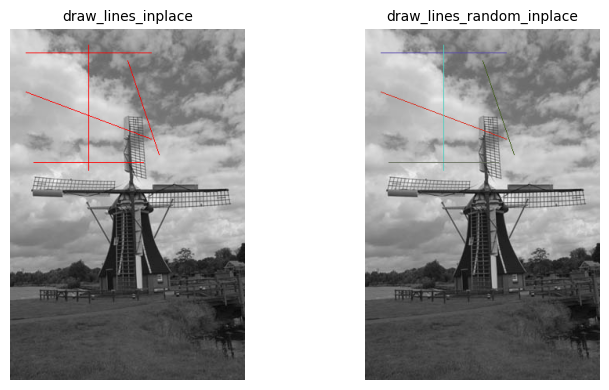

In [54]:
# draw_lines_inplace — draws directly on the source image (modifies it)
wm_copy = np.stack([windmill]*3, axis=-1).copy()  # grayscale → BGR
le_geometry.draw_lines_inplace(wm_copy, segments)

# draw_lines_random_inplace
wm_copy2 = np.stack([windmill]*3, axis=-1).copy()
le_geometry.draw_lines_random_inplace(wm_copy2, segments)

show_images(
    [bgr_to_rgb(wm_copy), bgr_to_rgb(wm_copy2)],
    ["draw_lines_inplace", "draw_lines_random_inplace"]
)

In [55]:
# Visualization helpers

# trim_to_box — clip infinite line to image bounds
inf_line = le_geometry.Line(0.5, 0.866, 100.0)  # 60° line
trimmed_seg = le_geometry.trim_to_box(inf_line, 300, 200)
print(f"Trimmed segment: {trimmed_seg.start_point()} → {trimmed_seg.end_point()}")

# random_color
for i in range(5):
    print(f"Random color {i}: {le_geometry.random_color()}")

# apply_border — add a border around an image
small = np.full((50, 80, 3), 200, dtype=np.uint8)
bordered = le_geometry.apply_border(small, 10)
print(f"\nBefore border: {small.shape}, After: {bordered.shape}")

Trimmed segment: (0.0, 115.47344970703125) → (200.0, 0.0)
Random color 0: (168.48840158561697, 177.40902005431, 158.07826054136018, 0.0)
Random color 1: (120.26311344438297, 218.648044346857, 45.94721027797041, 0.0)
Random color 2: (70.70965812729762, 47.92244041997603, 59.27277129790359, 0.0)
Random color 3: (67.177034861825, 137.3298458041625, 130.57876727283144, 0.0)
Random color 4: (36.95351844040947, 40.3488956661662, 188.4979690462062, 0.0)

Before border: (50, 80, 3), After: (70, 100, 3)


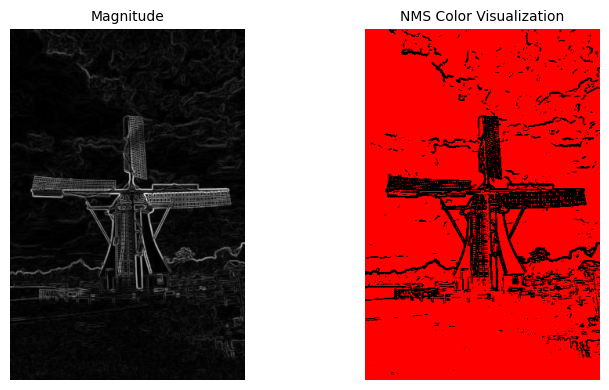

In [57]:
# NMS color visualization — creates a color-coded map from edge direction map
# The function takes a single edge map (typically from NMS)
sobel_wm.process(windmill)

# Create a simple edge map for visualization (threshold magnitude)
mag = sobel_wm.magnitude()
edge_map = (mag > mag.max() * 0.1).astype(np.uint8) * 255

# create_nms_color expects an edge direction image (8-bit)
nms_vis = le_geometry.create_nms_color(edge_map)

show_images(
    [mag, bgr_to_rgb(nms_vis)],
    ["Magnitude", "NMS Color Visualization"]
)

### Exercise 10.1 — Visualize Detected Segments

1. Create a synthetic image with a known pattern (e.g., a cross or grid).
2. Manually define line segments that match the pattern.
3. Use `draw_lines_random` to overlay them on the image.
4. Use `draw_lines_labeled` with descriptive labels.

In [58]:
# TODO: create synthetic image with pattern, define matching segments, draw

**Solution**

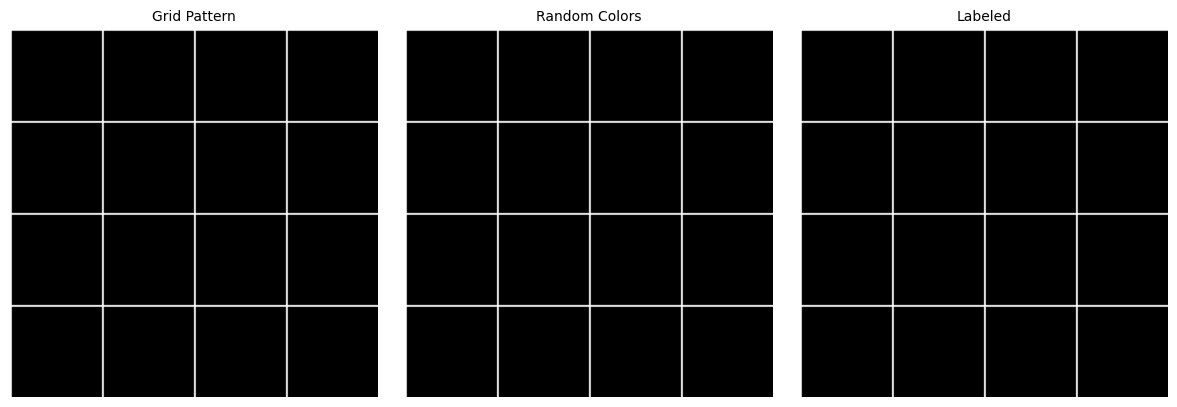

In [59]:
# Create a grid pattern
grid = np.zeros((200, 200), dtype=np.uint8)
for x in range(0, 200, 50):
    grid[:, x] = 255  # vertical lines
for y in range(0, 200, 50):
    grid[y, :] = 255  # horizontal lines

# Matching segments
grid_segs = []
grid_labels = []
for x in range(0, 200, 50):
    grid_segs.append(le_geometry.LineSegment.from_endpoints(float(x), 0.0, float(x), 199.0))
    grid_labels.append(f"V{x}")
for y in range(0, 200, 50):
    grid_segs.append(le_geometry.LineSegment.from_endpoints(0.0, float(y), 199.0, float(y)))
    grid_labels.append(f"H{y}")

canvas1 = np.stack([grid]*3, axis=-1).copy()
le_geometry.draw_lines_random(canvas1, grid_segs)

canvas2 = np.stack([grid]*3, axis=-1).copy()
le_geometry.draw_lines_labeled(canvas2, grid_segs, grid_labels)

show_images(
    [grid, bgr_to_rgb(canvas1), bgr_to_rgb(canvas2)],
    ["Grid Pattern", "Random Colors", "Labeled"]
)

The drawing functions make it easy to overlay detected (or manually defined)
line segments on images with consistent styling.

---
## Summary

You now know how to use the foundational LineExtraction Python modules:

| Module | Key Classes/Functions |
|--------|----------------------|
| `lsfm.data` | `TestImages` — windmill, BSDS500, noise, stereo |
| `le_imgproc` | `Range*`, `Value`, `FilterData`, `SobelGradient`, `ScharrGradient`, `PrewittGradient` |
| `le_geometry` | `Line`, `LineSegment`, `Polygon`, `draw_lines*`, `create_nms_color`, `random_color` |

**Key patterns:**
- `.process(img)` → compute, then access results via `.magnitude()`, `.gx()`, etc.
- `.values()` / `.get_value()` / `.set_int()` — runtime parameter access (ValueManager)
- BGR color convention — use `[:,:,::-1]` for matplotlib
- Multiple presets (`_f32`, `_f64`) for different precision needs

**Next:** Open **Tutorial 2 — Edge & Line Detection Pipelines**
(`tutorial_2_pipelines.ipynb`) to learn the detection algorithms.